In [2]:
from datetime import datetime, timedelta
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [3]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [4]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

In [173]:
s = time.time()
# data = get_data(get_all_tickers())
data = get_data("NOK")
data_cop = data.copy()
print(time.time() - s)

[*********************100%***********************]  1 of 1 completed
0.6476154327392578


### Strategy and more shit

### Parsing initial dataframe

In [143]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["High"].rolling(window_size).max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [164]:
def strategy(parsed_data):
    df = parsed_data.copy()

    time_thresh1 = timedelta(days=75)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=200)  
    
    # Buy signal
    buy_cond = df["High"].shift(-1) > df["High52"]
    buy_cond2 = (df.index - df["doh"] < time_thresh2)  & (df.index - df["doh"] > time_thresh1)
    
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    # Sell cond- sell after 3 days, just for testing because I don't know yet how I should do it
    sell_cond = df["Strategy"].shift(3) == 1
    df.loc[sell_cond, "Strategy"] = -1
    
    # Position
    df.loc[df['Strategy'] == 1, 'pos'] = 1
    df.loc[df['Strategy'] == -1, 'pos'] = 0
    # df["Stocks bought"] = df["pos"] * s_money//df["Open"]
    # df['Stocks bought'] = df['Stocks bought'].replace(to_replace=np.nan, method='ffill')
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    
    return df

In [163]:
def sim(df1):
    df = df1.copy()
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    return df

In [174]:
df = strategy(parse_data(data_cop))
df = sim(df)
df

Open  High  Close    Volume  High52        doh  Strategy  pos  \
Date                                                                        
1994-07-01  1.29  1.32   1.32  29958400     NaN 1900-01-01         0  NaN   
1994-07-05  1.36  1.37   1.37  10691200     NaN 1900-01-01         0  NaN   
1994-07-06  1.37  1.41   1.41   7408000     NaN 1900-01-01         0  NaN   
1994-07-07  1.41  1.43   1.43   9747200     NaN 1900-01-01         0  NaN   
1994-07-08  1.43  1.45   1.44   4467200     NaN 1900-01-01         0  NaN   
...          ...   ...    ...       ...     ...        ...       ...  ...   
2023-08-24  3.80  3.83   3.77  10844000    5.19 2023-08-15         0 0.00   
2023-08-25  3.78  3.81   3.80  11059800    5.19 2023-08-15         0 0.00   
2023-08-28  3.81  3.85   3.85   5953600    5.19 2023-08-15         0 0.00   
2023-08-29  3.94  3.96   3.95  15483300    5.19 2023-08-15         0 0.00   
2023-08-30  3.98  3.99   3.98  10872519    5.19 2023-08-15         0 0.00   

            Day profit  Hold  sReturn  hReturn  
Date                                            
1994-07-01         NaN   NaN      NaN      NaN  
1994-07-05         NaN  0.04      NaN     1.04  
1994-07-06         NaN  0.03      NaN     1.07  
1994-07-07         NaN  0.01      NaN     1.09  
1994-07-08         NaN  0.01      NaN     1.09  
...                ...   ...      ...      ...  
2023-08-24       -0.00 -0.02     2.57     2.86  
2023-08-25        0.00  0.01     2.57     2.89  
2023-08-28        0.00  0.01     2.57     2.92  
2023-08-29        0.00  0.03     2.57     3.00  
2023-08-30        0.00  0.01     2.57     3.02  

[7343 rows x 12 columns]

In [98]:
df["pos"].value_counts()
df.index[df['pos'] == 1].tolist()[:10]

[Timestamp('1965-04-14 00:00:00'),
 Timestamp('1965-04-15 00:00:00'),
 Timestamp('1965-04-19 00:00:00'),
 Timestamp('1965-07-23 00:00:00'),
 Timestamp('1965-07-26 00:00:00'),
 Timestamp('1965-07-27 00:00:00'),
 Timestamp('1975-03-07 00:00:00'),
 Timestamp('1975-03-10 00:00:00'),
 Timestamp('1975-03-11 00:00:00'),
 Timestamp('1978-02-08 00:00:00')]

<Axes: xlabel='Date'>

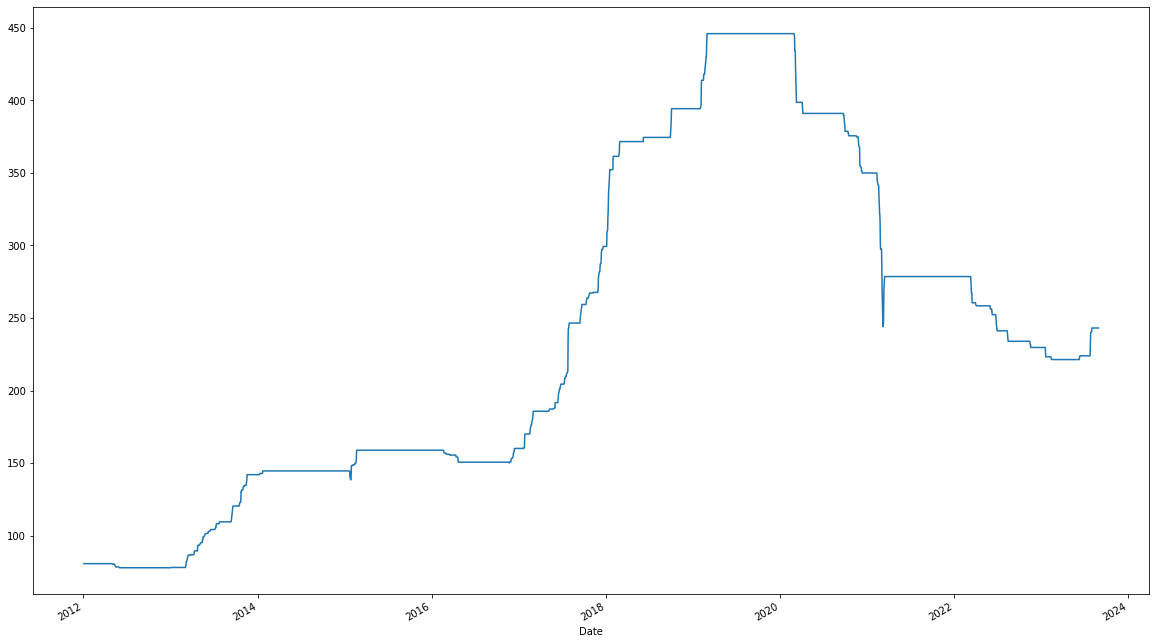

In [99]:
df['2012-01-01':'2023-12-31']["High52"].plot(figsize=(20,12))

In [136]:
df[815:835]

Open  High  Close   Volume  High52        doh  Strategy  pos
Date                                                                    
1965-03-29  1.01  1.02   1.00   978075    1.18 1964-12-21         0  NaN
1965-03-30  1.00  1.02   1.02   528525    1.18 1964-12-21         0  NaN
1965-03-31  1.02  1.05   1.03  1160325    1.18 1964-12-21         0  NaN
1965-04-01  1.03  1.03   1.02   558900    1.18 1964-12-21         0  NaN
1965-04-02  1.02  1.04   1.04  1008450    1.18 1964-12-21         0  NaN
1965-04-05  1.04  1.09   1.08  2351025    1.18 1964-12-21         0  NaN
1965-04-06  1.08  1.09   1.08  1998675    1.18 1964-12-21         0  NaN
1965-04-07  1.08  1.09   1.08   729000    1.18 1964-12-21         0  NaN
1965-04-08  1.08  1.13   1.13  2782350    1.18 1964-12-21         0  NaN
1965-04-09  1.13  1.14   1.14  1579500    1.18 1964-12-21         0  NaN
1965-04-12  1.14  1.16   1.14  1464075    1.18 1964-12-21         0  NaN
1965-04-13  1.14  1.15   1.14   856575    1.18 1964-12-21         0  NaN
1965-04-14  1.14  1.18   1.18  2284200    1.18 1964-12-21         1 1.00
1965-04-15  1.18  1.19   1.19  1670625    1.19 1965-04-15         0 1.00
1965-04-19  1.19  1.21   1.21  1476225    1.21 1965-04-19         0 1.00
1965-04-20  1.21  1.21   1.20   753300    1.21 1965-04-20        -1 0.00
1965-04-21  1.20  1.21   1.20  1032750    1.21 1965-04-20         0 0.00
1965-04-22  1.20  1.21   1.21   376650    1.21 1965-04-20         0 0.00
1965-04-23  1.21  1.22   1.22   807975    1.22 1965-04-23         0 0.00
1965-04-26  1.22  1.26   1.26  1980450    1.26 1965-04-26         0 0.00

In [175]:
df["pos"].value_counts()

0.00    6587
1.00      27
Name: pos, dtype: int64

In [155]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp)

Day profit     1.42
Hold         161.30
dtype: float64

In [115]:
df["Day profit"].nlargest(5)

Date
1984-08-03   0.05
1975-03-10   0.05
1993-12-07   0.05
1978-02-09   0.05
1965-07-26   0.04
Name: Day profit, dtype: float64